### Libraries

In [36]:
import pandas as pd
import librosa
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

### Data Gathering

In [37]:
# Load metadata (track information including genre)
metadata_path = 'fma_metadata/tracks.csv'
tracks = pd.read_csv(metadata_path, index_col=0, header=[0, 1])

# Extract relevant columns from the metadata (track ID and genre)
genre_info = tracks['track', 'genre_top'].dropna()

## Feature Extraction

In [38]:
# Function to extract features from a single track
def extract_features(track_path):
    try:
        y, sr = librosa.load(track_path, sr=None, duration=30)
        # MFCCs, Chroma, Spectral Contrast, Tonnetz, Tempo, and Spectral Centroid
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)

        # Return the concatenated features
        return np.hstack((mfccs, chroma, spectral_contrast, tonnetz, tempo, spectral_centroid))
    except Exception as e:
        print(f"Error processing {track_path}: {e}")
        return None

# Extract features and labels from the 'fma_small_filtered' dataset
features_list = []
labels_list = []
for file_name in os.listdir('fma_small_filtered'):
    if file_name.endswith('.mp3'):
        track_path = os.path.join('fma_small_filtered', file_name)
        features = extract_features(track_path)
        if features is not None:
            features_list.append(features)
            track_id = int(file_name.split('.')[0])
            if track_id in genre_info.index:
                genre = genre_info.loc[track_id]
                labels_list.append(genre)

### Feature Statistical Analysis

<Figure size 1800x1200 with 0 Axes>

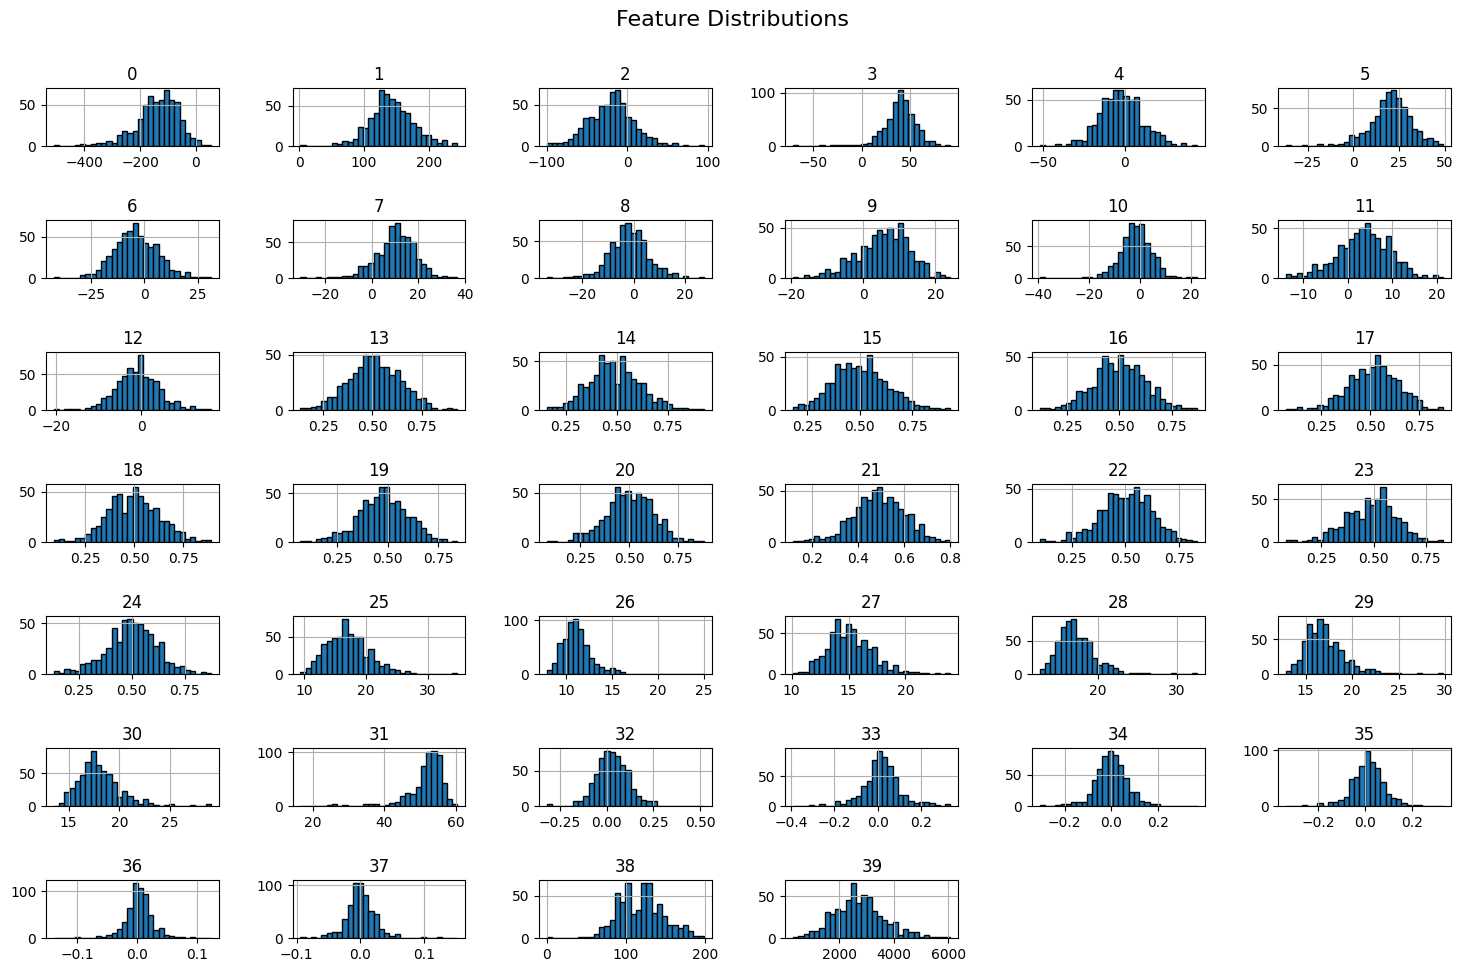

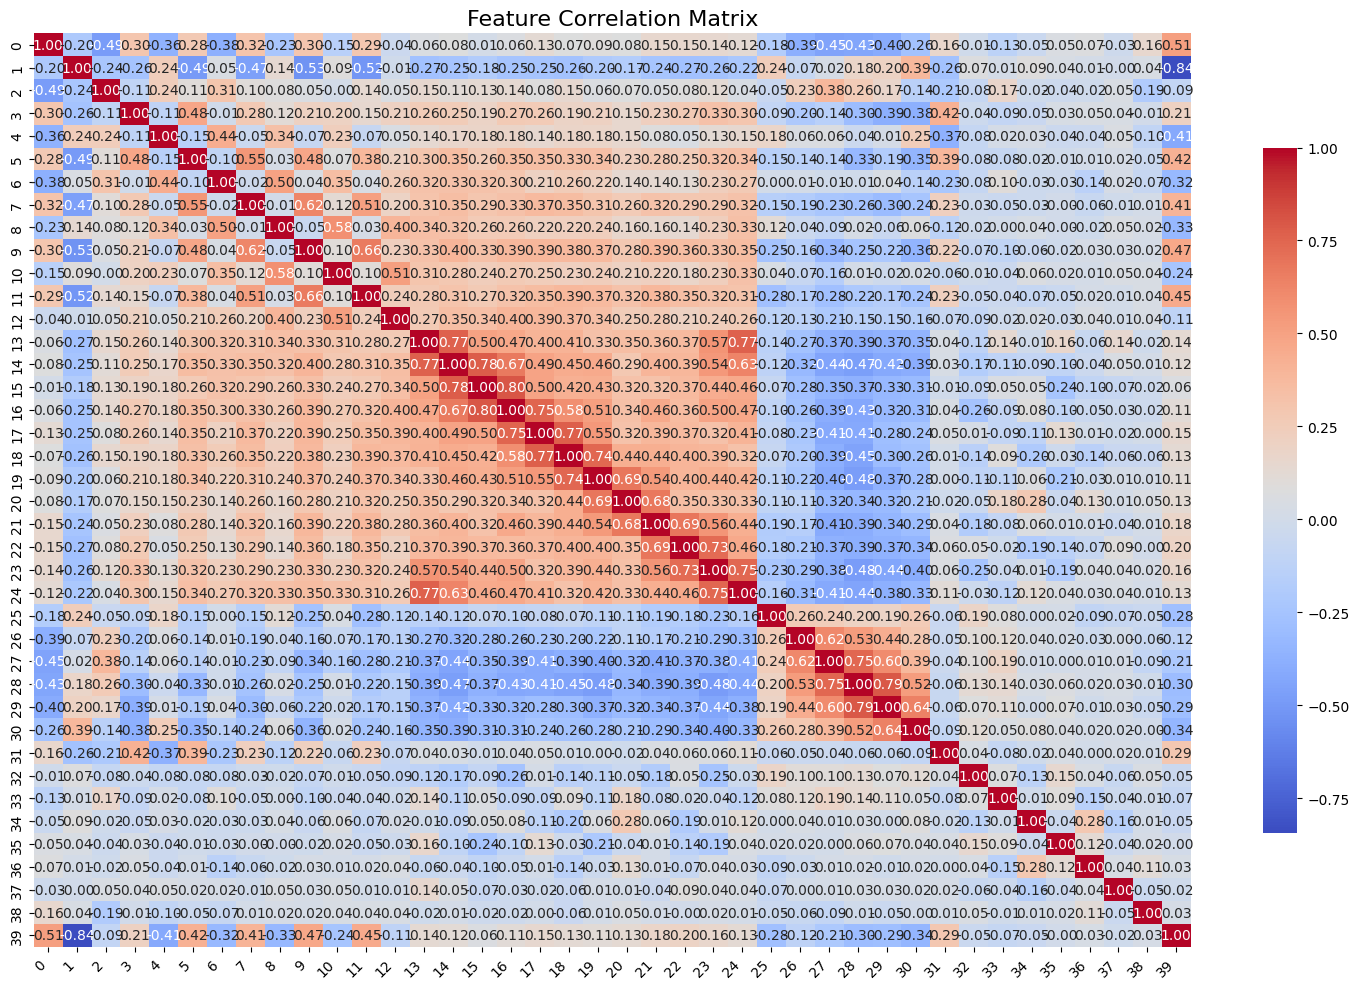

In [69]:
# Convert features list to DataFrame
features_df = pd.DataFrame(features_list)

# Plot histograms for each feature
plt.figure(figsize=(18, 12))  
features_df.hist(bins=30, figsize=(15, 10), edgecolor='black') 
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout(pad=2.0)  # Add padding between subplots
plt.show()

# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10}, 
            cbar_kws={"shrink": 0.75})  
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.yticks(fontsize=10)  
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()  
plt.show()


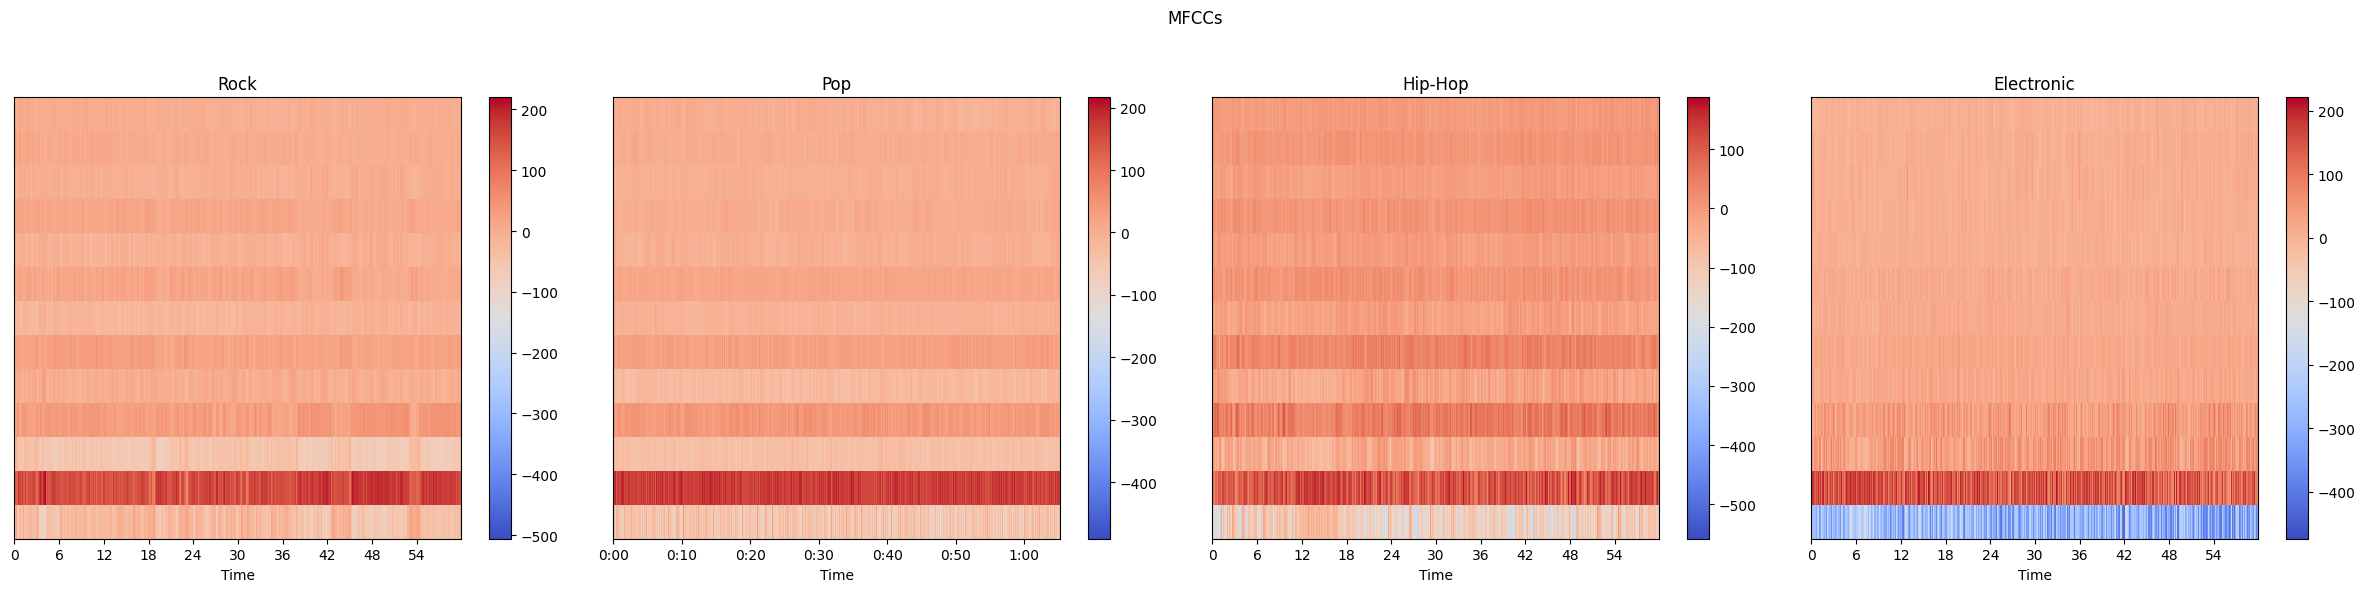

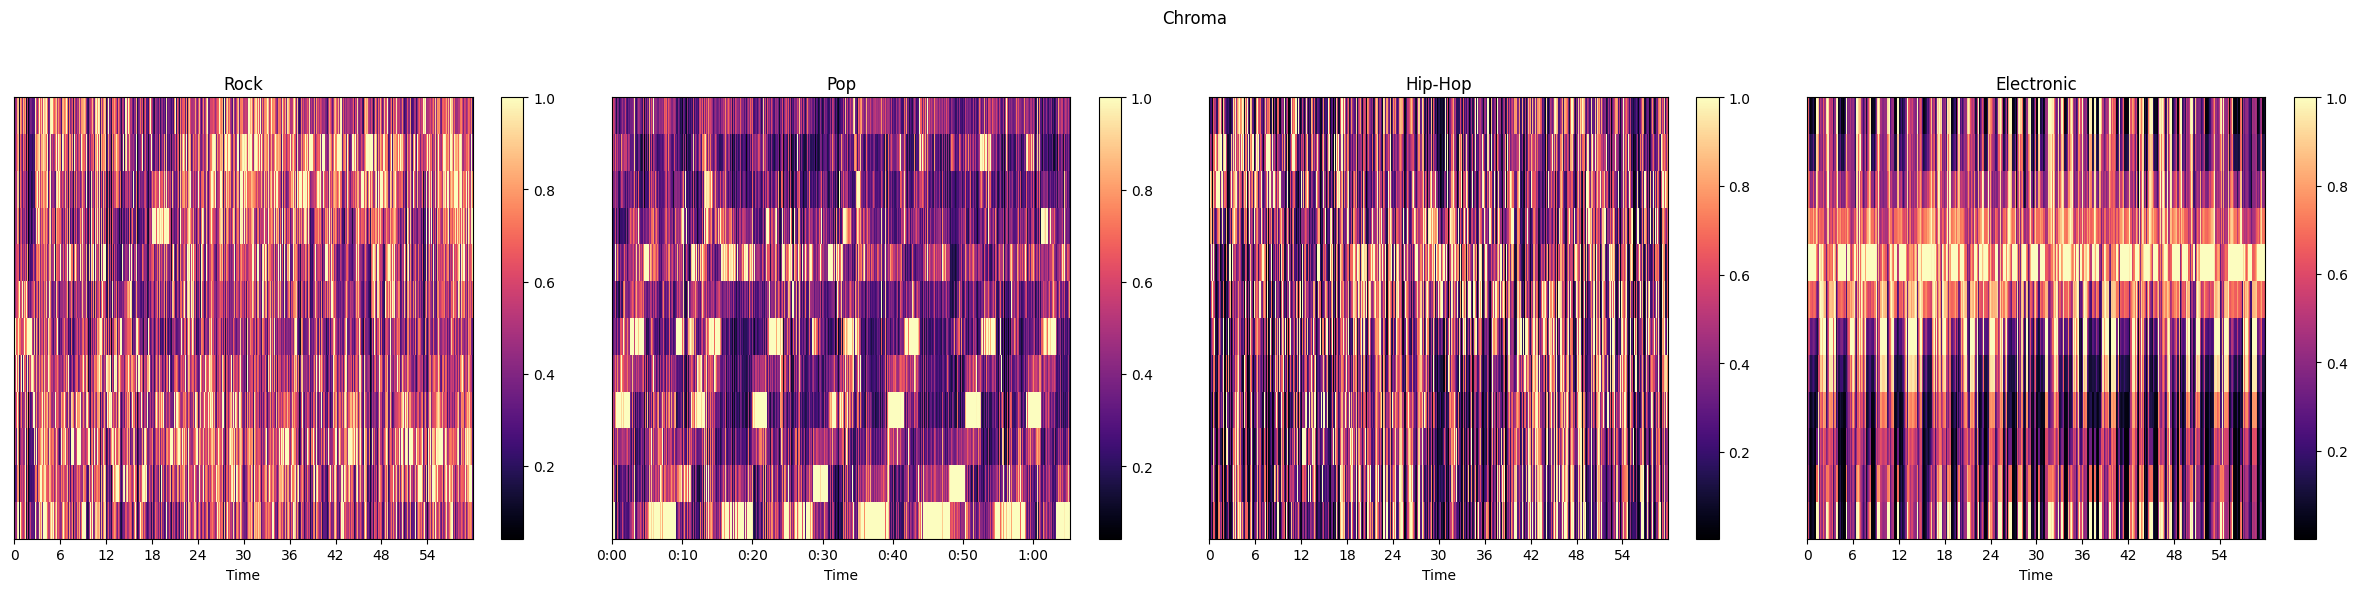

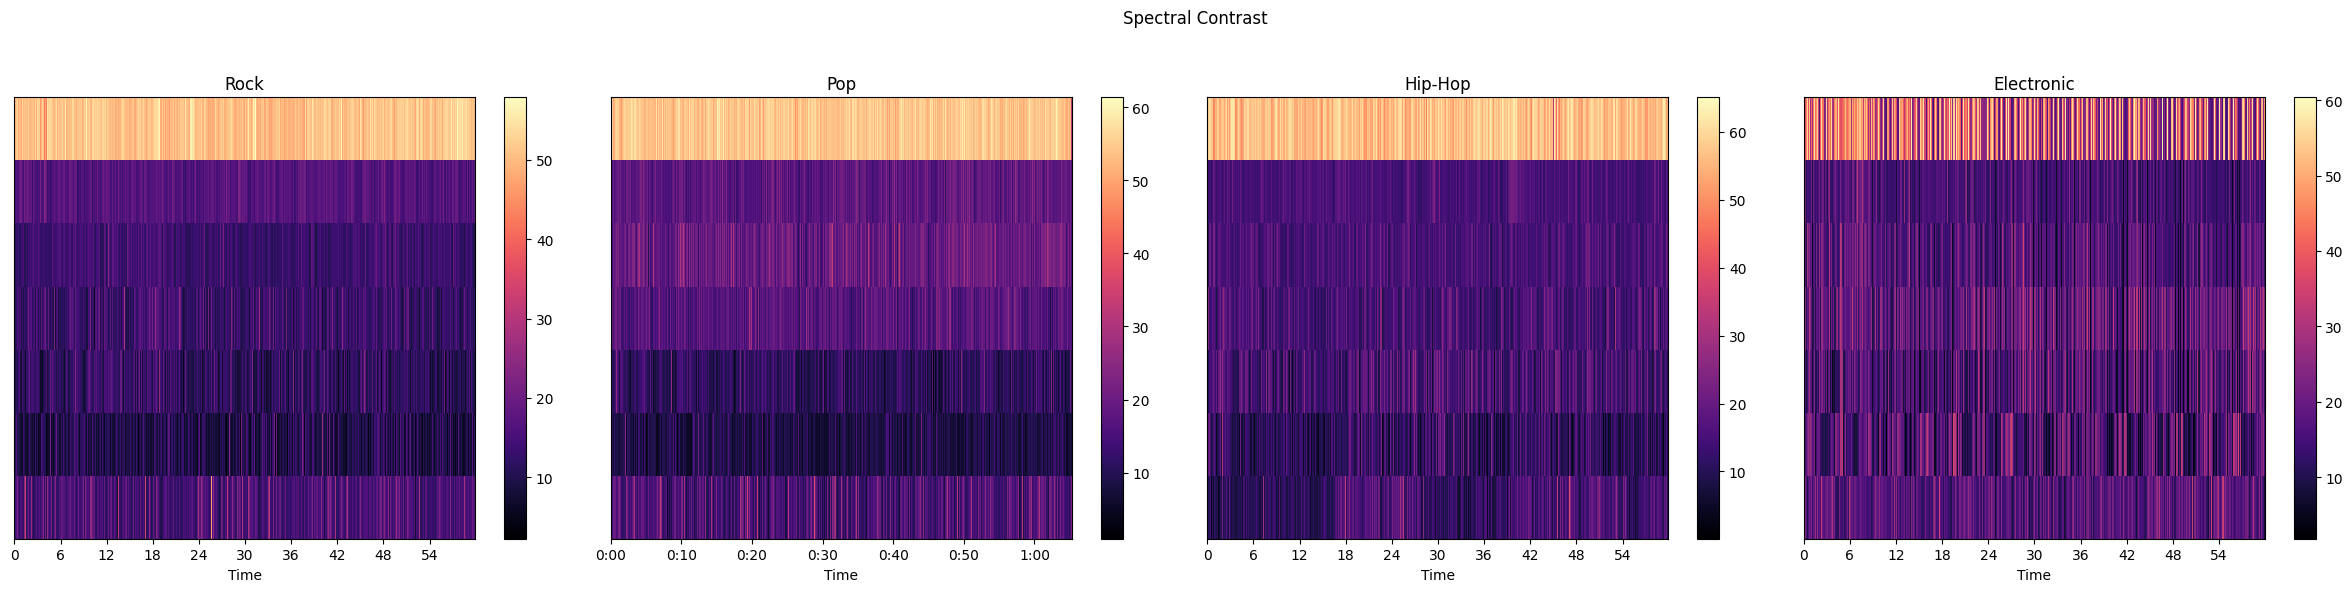

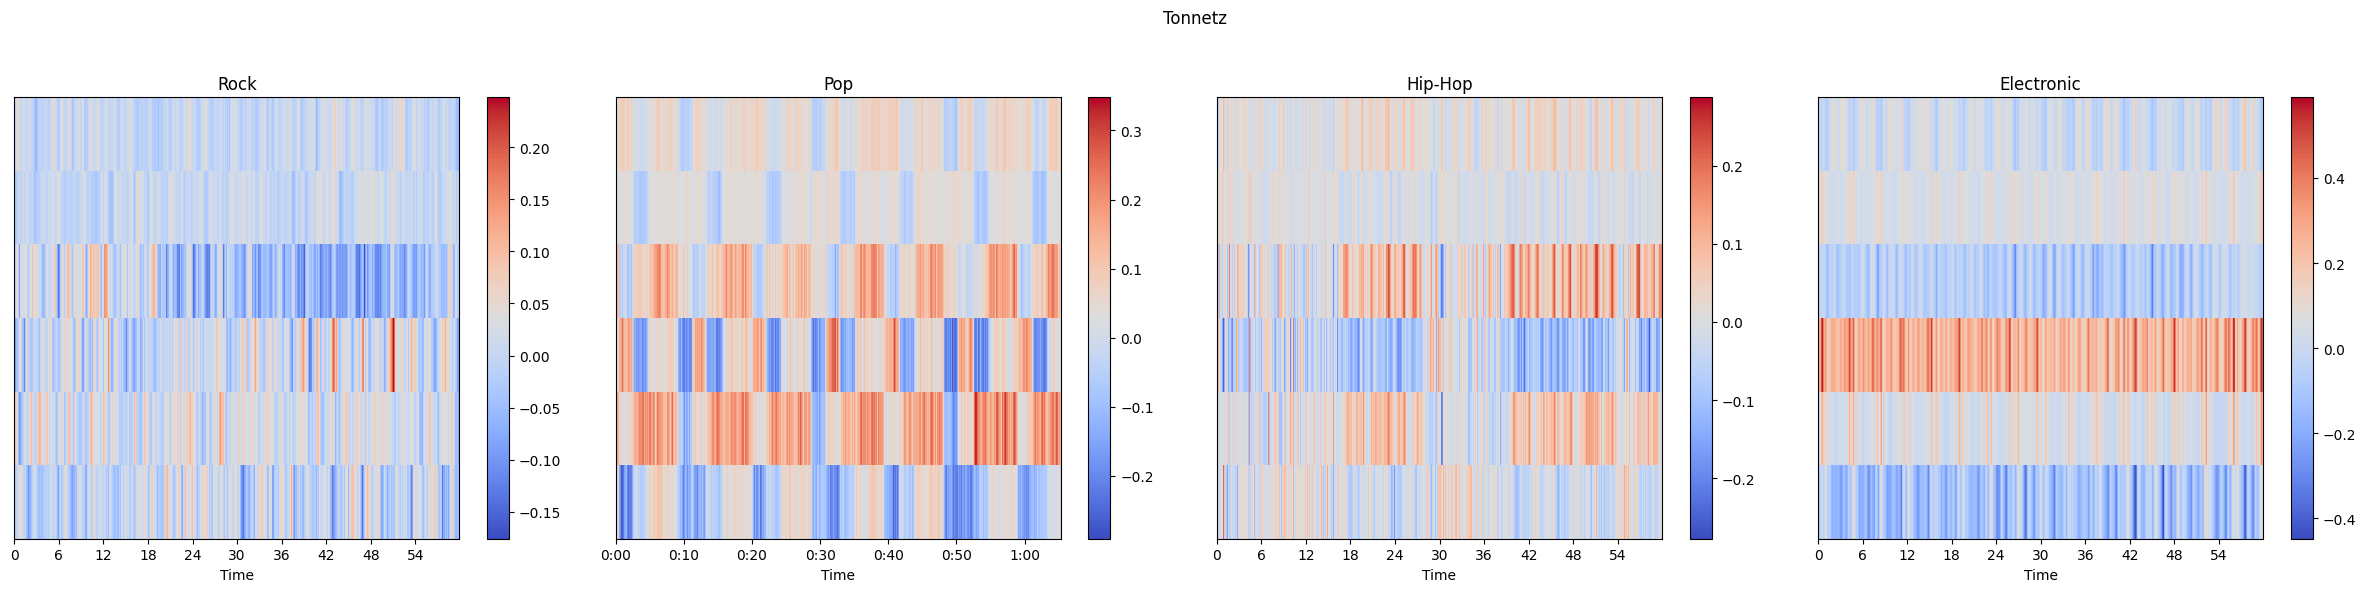

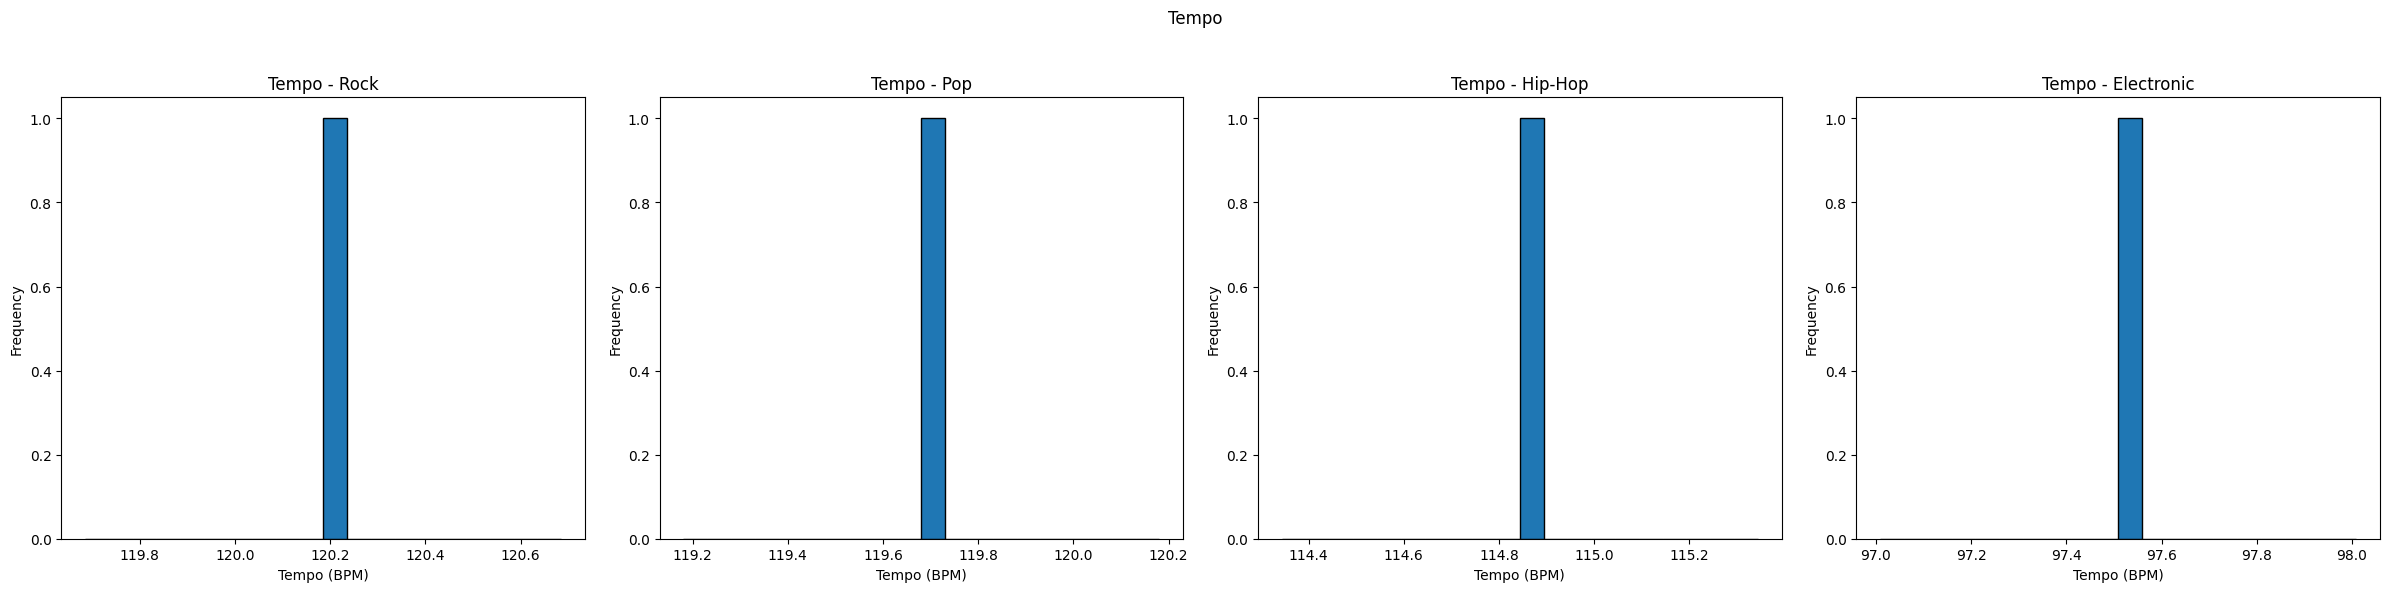

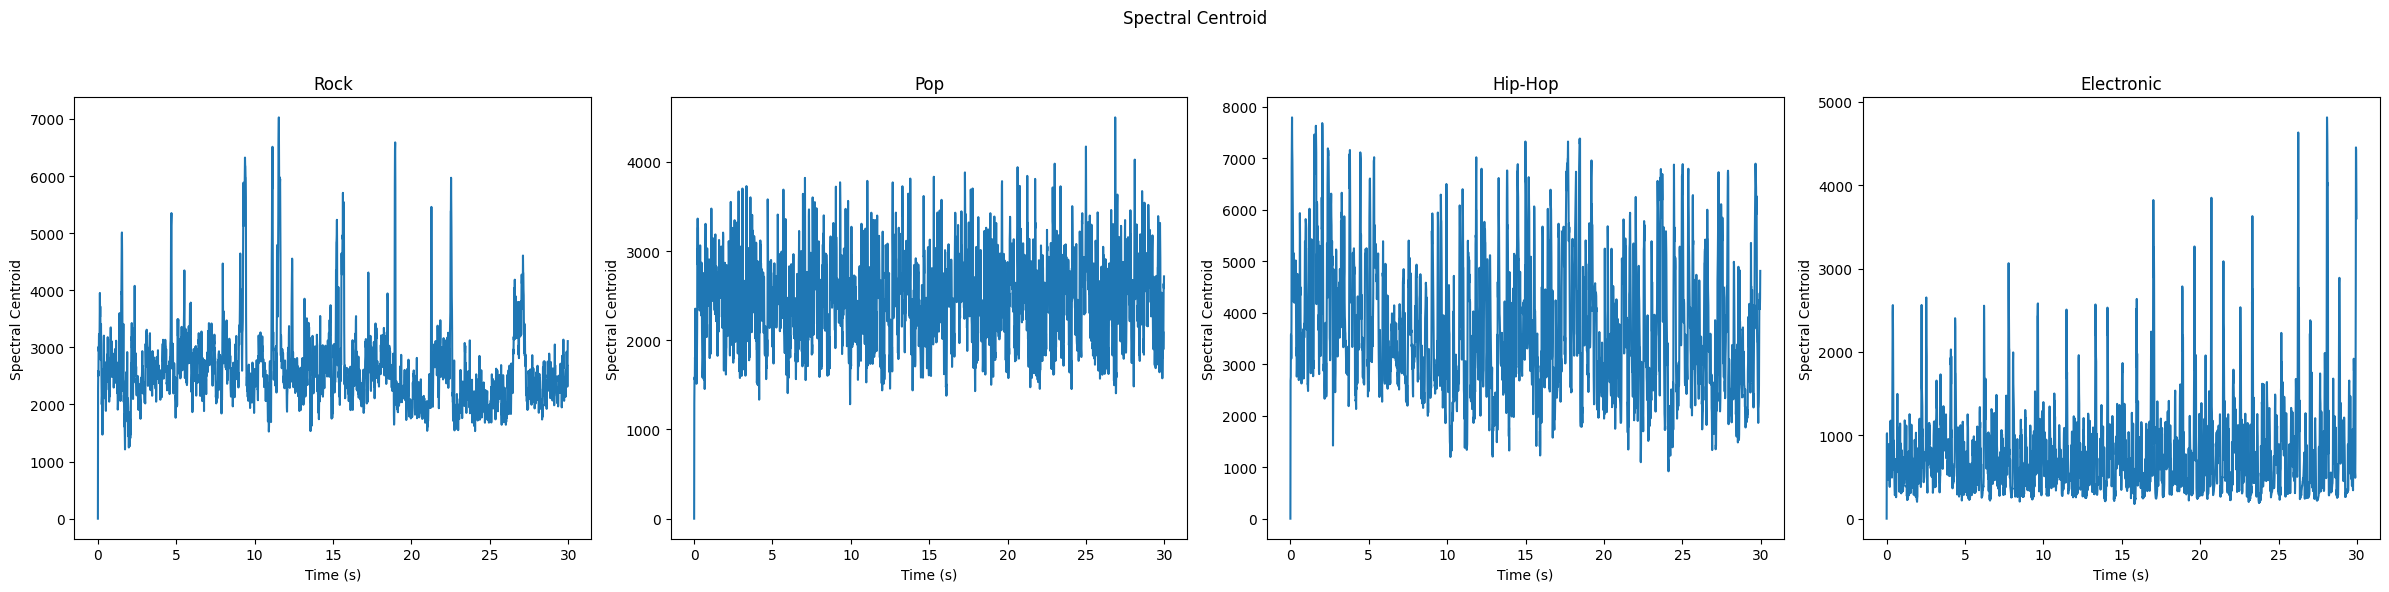

In [42]:
# Define file paths for Rock, Pop, Hip-Hop, and Electronic tracks
rock_track_path = 'fma_small_filtered/000256.mp3'
pop_track_path = 'fma_small_filtered/001649.mp3'
hiphop_track_path = 'fma_small_filtered/000694.mp3'
electronic_track_path = 'fma_small_filtered/001482.mp3'

# Function to extract features from a track
def extract_features(track_path):
    y, sr = librosa.load(track_path, sr=None, duration=30)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=1024, hop_length=512)[0]
    return mfccs, chroma, spectral_contrast, tonnetz, tempo, spectral_centroid,sr

# Extract features for each genre
features_rock = extract_features(rock_track_path)
features_pop = extract_features(pop_track_path)
features_hiphop = extract_features(hiphop_track_path)
features_electronic = extract_features(electronic_track_path)

# Unpack features and sampling rates
mfccs_rock, chroma_rock, spectral_contrast_rock, tonnetz_rock, tempo_rock, spectral_centroid_rock, sr_rock = features_rock
mfccs_pop, chroma_pop, spectral_contrast_pop, tonnetz_pop, tempo_pop, spectral_centroid_pop, sr_pop = features_pop
mfccs_hiphop, chroma_hiphop, spectral_contrast_hiphop, tonnetz_hiphop, tempo_hiphop, spectral_centroid_hiphop, sr_hiphop = features_hiphop
mfccs_electronic, chroma_electronic, spectral_contrast_electronic, tonnetz_electronic, tempo_electronic, spectral_centroid_electronic, sr_electronic = features_electronic


# Feature names
feature_names = ['MFCCs', 'Chroma', 'Spectral Contrast', 'Tonnetz', 'Tempo', 'Spectral Centroid']
feature_data = {
    'MFCCs': (features_rock[0], features_pop[0], features_hiphop[0], features_electronic[0]),
    'Chroma': (features_rock[1], features_pop[1], features_hiphop[1], features_electronic[1]),
    'Spectral Contrast': (features_rock[2], features_pop[2], features_hiphop[2], features_electronic[2]),
    'Tonnetz': (features_rock[3], features_pop[3], features_hiphop[3], features_electronic[3]),
    'Tempo': (features_rock[4], features_pop[4], features_hiphop[4], features_electronic[4]),
    'Spectral Centroid': (features_rock[5], features_pop[5], features_hiphop[5], features_electronic[5])
}

# Plot each feature
for feature_name in feature_names:
    data = feature_data[feature_name]
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    
    # Rock
    if feature_name == 'Tempo':
        axs[0].hist(data[0], bins=20, edgecolor='black')
        axs[0].set_title('Tempo - Rock')
        axs[0].set_xlabel('Tempo (BPM)')
        axs[0].set_ylabel('Frequency')
    elif feature_name == 'Spectral Centroid':
        frames_rock = range(len(features_rock[5]))
        t_rock = librosa.frames_to_time(frames_rock, sr=sr_rock, hop_length=512)
        axs[0].plot(t_rock,features_rock[5])
        axs[0].set_title('Rock')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Spectral Centroid')
        
    else:
        librosa.display.specshow(data[0], x_axis='time', ax=axs[0])
        axs[0].set_title('Rock')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel(feature_name)
        fig.colorbar(librosa.display.specshow(data[0], x_axis='time', ax=axs[0]), ax=axs[0])
    
    # Pop
    if feature_name == 'Tempo':
        axs[1].hist(data[1], bins=20, edgecolor='black')
        axs[1].set_title('Tempo - Pop')
        axs[1].set_xlabel('Tempo (BPM)')
        axs[1].set_ylabel('Frequency')
    elif feature_name == 'Spectral Centroid':
        frames_pop = range(len(features_pop[5]))
        t_pop = librosa.frames_to_time(frames_pop, sr=sr_pop, hop_length=512)
        axs[1].plot(t_pop, features_pop[5])
        axs[1].set_title('Pop')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('Spectral Centroid')
    else:
        librosa.display.specshow(data[1], x_axis='time', ax=axs[1])
        axs[1].set_title('Pop')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel(feature_name)
        fig.colorbar(librosa.display.specshow(data[1], x_axis='time', ax=axs[1]), ax=axs[1])

    # Hip-Hop
    if feature_name == 'Tempo':
        axs[2].hist(data[2], bins=20, edgecolor='black')
        axs[2].set_title('Tempo - Hip-Hop')
        axs[2].set_xlabel('Tempo (BPM)')
        axs[2].set_ylabel('Frequency')
    elif feature_name == 'Spectral Centroid':
        frames_hiphop = range(len(features_hiphop[5]))
        t_hiphop = librosa.frames_to_time(frames_hiphop, sr=sr_hiphop, hop_length=512)
        axs[2].plot(t_hiphop,features_hiphop[5])
        axs[2].set_title('Hip-Hop')
        axs[2].set_xlabel('Time (s)')
        axs[2].set_ylabel('Spectral Centroid')
    else:
        librosa.display.specshow(data[2], x_axis='time', ax=axs[2])
        axs[2].set_title('Hip-Hop')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel(feature_name)
        fig.colorbar(librosa.display.specshow(data[2], x_axis='time', ax=axs[2]), ax=axs[2])

    # Electronic
    if feature_name == 'Tempo':
        axs[3].hist(data[3], bins=20, edgecolor='black')
        axs[3].set_title('Tempo - Electronic')
        axs[3].set_xlabel('Tempo (BPM)')
        axs[3].set_ylabel('Frequency')
    elif feature_name == 'Spectral Centroid':
        frames_electronic = range(len(features_electronic[5]))
        t_electronic = librosa.frames_to_time(frames_electronic, sr=sr_electronic, hop_length=512)
        axs[3].plot(t_electronic, features_electronic[5])
        axs[3].set_title('Electronic')
        axs[3].set_xlabel('Time (s)')
        axs[3].set_ylabel('Spectral Centroid')
    else:
        librosa.display.specshow(data[3], x_axis='time', ax=axs[3])
        axs[3].set_title('Electronic')
        axs[3].set_xlabel('Time')
        axs[3].set_ylabel(feature_name)
        fig.colorbar(librosa.display.specshow(data[3], x_axis='time', ax=axs[3]), ax=axs[3])

    plt.suptitle(feature_name)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Data Preprocesing

In [60]:
# Convert to NumPy arrays for model training
X = np.array(features_list)
y = np.array(labels_list)

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode genre labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Plot the class distribution
class_counts = pd.Series(y).value_counts()
print("Class distribution:")
print(class_counts)

min_class_size = class_counts.min()
smote = SMOTE(k_neighbors=min_class_size-1,random_state=42)
X, y = smote.fit_resample(X, y_encoded)

# Check new class distribution
new_class_counts = pd.Series(y).value_counts()
print("\nClass distribution after SMOTE:")
print(new_class_counts)


Class distribution:
Hip-Hop       154
Pop           154
Electronic    143
Rock          129
Name: count, dtype: int64

Class distribution after SMOTE:
3    154
1    154
0    154
2    154
Name: count, dtype: int64


## Cross Validation

In [72]:
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define different classifiers to compare
classifiers = {
    "SVM": SVC(kernel='rbf', random_state=42,C=10,gamma=0.006483534286054721),
    "KNN": KNeighborsClassifier(n_neighbors=15,weights='uniform'),
    "Decision Tree": DecisionTreeClassifier(random_state=42,max_depth=7,min_samples_split=5),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,100), max_iter=700, random_state=42,activation='relu',solver='sgd',learning_rate='constant',alpha=0.0001)
}
# Define additional metrics to evaluate
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Prepare a dictionary to hold the results
results = {metric: [] for metric in scoring.keys()}

# Perform cross-validation on the training set
for name, clf in classifiers.items():
    # Perform cross-validation
    cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Calculate means and standard deviations
    for metric in scoring.keys():
        mean = np.mean(cv_results[f'test_{metric}'])
        #std = np.std(cv_results[f'test_{metric}'])
        results[metric].append(f"{mean:.2f}")
        #results[metric].append(f"{mean:.2f} ± {std:.2f}")

# Create a DataFrame from the results
results_df = pd.DataFrame(results, index=classifiers.keys())

# Print the results table
print("Performance Metrics Across Different Models:")
print(results_df)

d:\University\Μεταπτυχιακό - ΣΜΗΝ\Θερινό\Επεξεργασία Ήχου\Τελική Εργασία\sound\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\University\Μεταπτυχιακό - ΣΜΗΝ\Θερινό\Επεξεργασία Ήχου\Τελική Εργασία\sound\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\University\Μεταπτυχιακό - ΣΜΗΝ\Θερινό\Επεξεργασία Ήχου\Τελική Εργασία\sound\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\University\Μεταπτυχιακό - ΣΜΗΝ\Θερινό\Επεξεργασία Ήχου\Τελική Εργασία\sound\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron

Performance Metrics Across Different Models:
                   accuracy precision recall    f1
SVM                    0.57      0.57   0.57  0.56
KNN                    0.52      0.53   0.51  0.50
Decision Tree          0.48      0.48   0.48  0.47
MLP Neural Network     0.55      0.56   0.55  0.55


d:\University\Μεταπτυχιακό - ΣΜΗΝ\Θερινό\Επεξεργασία Ήχου\Τελική Εργασία\sound\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


## Train - Test Models


Training and evaluating SVM...
Accuracy for SVM: 0.53
Classification Report for SVM:
              precision    recall  f1-score   support

  Electronic       0.60      0.57      0.59        51
     Hip-Hop       0.53      0.49      0.51        47
         Pop       0.39      0.40      0.40        47
        Rock       0.60      0.68      0.64        40

    accuracy                           0.53       185
   macro avg       0.53      0.53      0.53       185
weighted avg       0.53      0.53      0.53       185


Training and evaluating KNN...
Accuracy for KNN: 0.55
Classification Report for KNN:
              precision    recall  f1-score   support

  Electronic       0.65      0.59      0.62        51
     Hip-Hop       0.52      0.53      0.53        47
         Pop       0.49      0.36      0.41        47
        Rock       0.52      0.72      0.60        40

    accuracy                           0.55       185
   macro avg       0.54      0.55      0.54       185
weighted avg 

d:\University\Μεταπτυχιακό - ΣΜΗΝ\Θερινό\Επεξεργασία Ήχου\Τελική Εργασία\sound\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for MLP Neural Network: 0.50
Classification Report for MLP Neural Network:
              precision    recall  f1-score   support

  Electronic       0.59      0.57      0.58        51
     Hip-Hop       0.50      0.40      0.45        47
         Pop       0.35      0.40      0.38        47
        Rock       0.59      0.65      0.62        40

    accuracy                           0.50       185
   macro avg       0.51      0.51      0.51       185
weighted avg       0.51      0.50      0.50       185



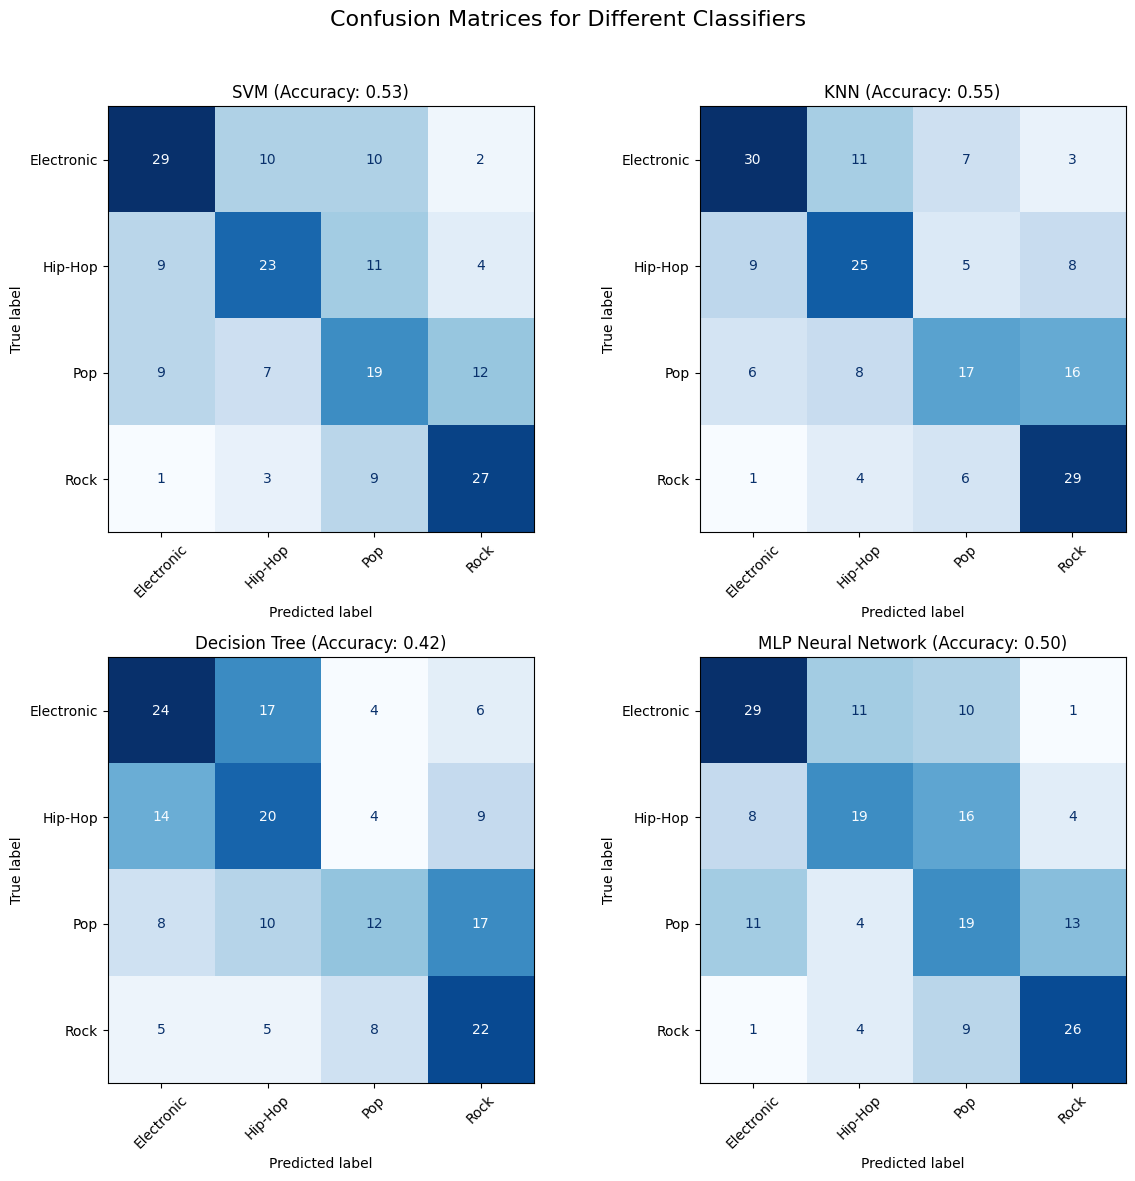

In [64]:
# Create a figure to hold all confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12)) 
fig.suptitle('Confusion Matrices for Different Classifiers', fontsize=16)
axes = axes.ravel()

# Train and evaluate each classifier
for idx, (clf_name, clf) in enumerate(classifiers.items()):
    print(f"\nTraining and evaluating {clf_name}...")
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.classes_[np.unique(y_test)], zero_division=0)
    
    print(f"Accuracy for {clf_name}: {accuracy:.2f}")
    print(f"Classification Report for {clf_name}:\n{report}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_[np.unique(y_test)])
    
    # Plot the confusion matrix on the corresponding subplot
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=False)
    axes[idx].set_title(f"{clf_name} (Accuracy: {accuracy:.2f})")
    axes[idx].tick_params(axis='x', labelrotation=45)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()

## Hyperparameter Tunning

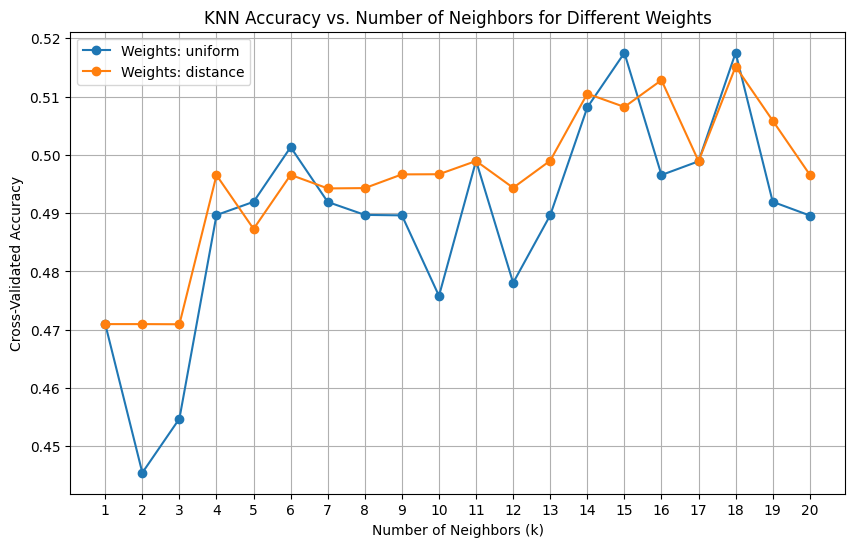

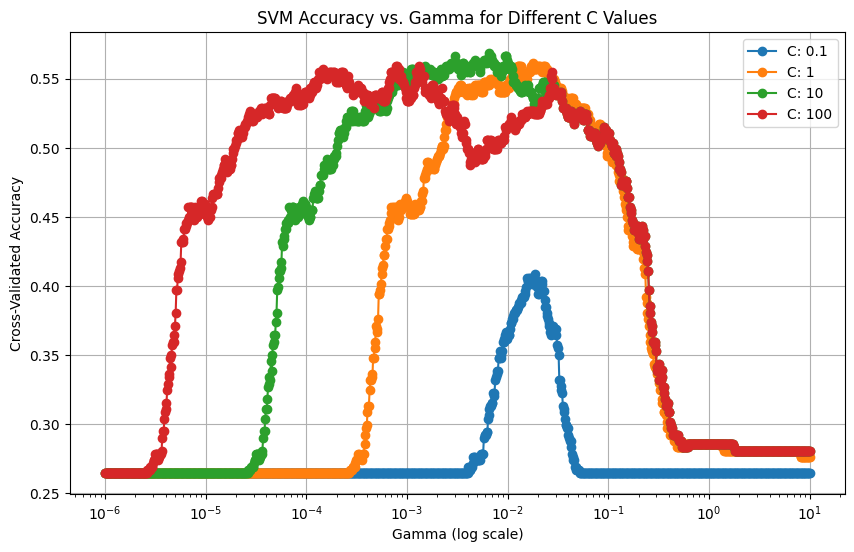

Optimal C: 10
Optimal Gamma: 0.006483534286054721
Best Cross-Validated Accuracy: 0.5685


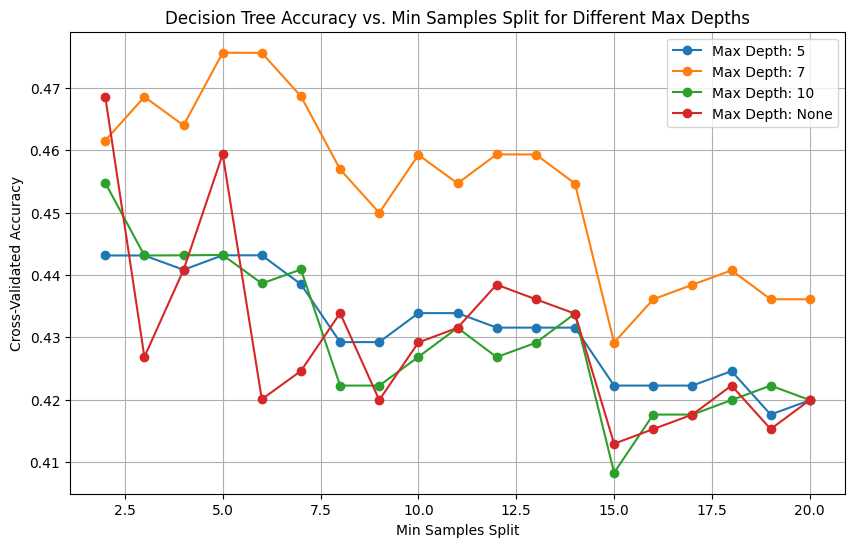

Optimal Max Depth: 7
Optimal Min Samples Split: 5
Best Cross-Validated Accuracy: 0.4756


d:\University\Μεταπτυχιακό - ΣΜΗΝ\Θερινό\Επεξεργασία Ήχου\Τελική Εργασία\sound\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Parameters for MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
Best Cross-Validated Accuracy for MLP: 0.5476


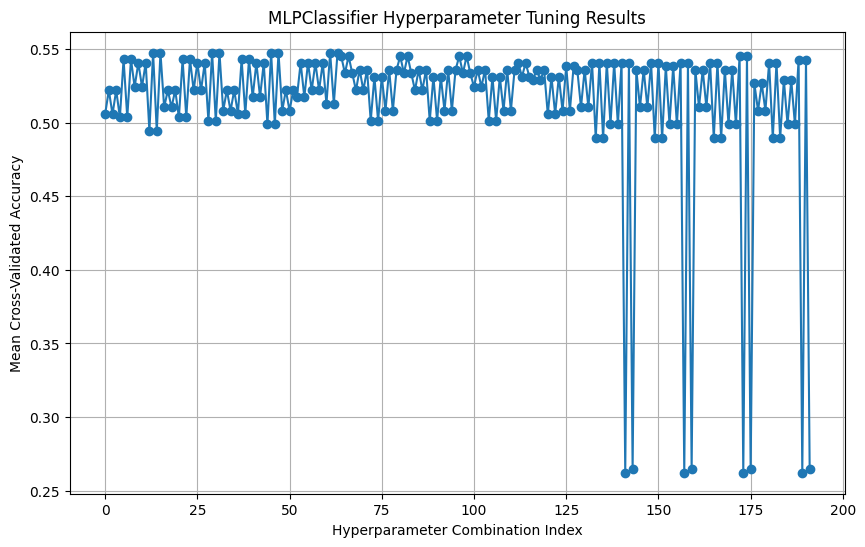

In [65]:
# 1. K-Nearest Neighbors (KNN) Hyperparameter Tuning
k_range = range(1, 21)
weights_options = ['uniform', 'distance']
mean_accuracies_knn = {weight: [] for weight in weights_options}

for weight in weights_options:
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        mean_accuracies_knn[weight].append(scores.mean())

plt.figure(figsize=(10, 6))
for weight in weights_options:
    plt.plot(k_range, mean_accuracies_knn[weight], marker='o', label=f'Weights: {weight}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors for Different Weights')
plt.grid(True)
plt.xticks(k_range)
plt.legend()
plt.show()

# 2. Support Vector Machine (SVM) Hyperparameter Tuning
C_range = [0.1, 1, 10, 100]
gamma_range = np.logspace(-6, 1, 1000)
mean_accuracies_svm = {C: [] for C in C_range}

best_accuracy_svm = 0
best_C_svm = None
best_gamma_svm = None

for C in C_range:
    for gamma in gamma_range:
        svm = SVC(C=C, gamma=gamma, kernel='rbf')
        scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
        mean_accuracy = scores.mean()
        mean_accuracies_svm[C].append(mean_accuracy)
        if mean_accuracy > best_accuracy_svm:
            best_accuracy_svm = mean_accuracy
            best_C_svm = C
            best_gamma_svm = gamma

plt.figure(figsize=(10, 6))
for C in C_range:
    plt.plot(gamma_range, mean_accuracies_svm[C], marker='o', label=f'C: {C}')
plt.xscale('log')
plt.xlabel('Gamma (log scale)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('SVM Accuracy vs. Gamma for Different C Values')
plt.grid(True)
plt.legend()
plt.show()

print(f"Optimal C: {best_C_svm}")
print(f"Optimal Gamma: {best_gamma_svm}")
print(f"Best Cross-Validated Accuracy: {best_accuracy_svm:.4f}")

# 3. Decision Tree Hyperparameter Tuning
max_depth_range = [5, 7, 10, None]
min_samples_split_range = np.arange(2, 21)
mean_accuracies_tree = {max_depth: [] for max_depth in max_depth_range}

best_accuracy_tree = 0
best_max_depth = None
best_min_samples_split = None

for max_depth in max_depth_range:
    for min_samples_split in min_samples_split_range:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
        mean_accuracy = scores.mean()
        mean_accuracies_tree[max_depth].append(mean_accuracy)
        if mean_accuracy > best_accuracy_tree:
            best_accuracy_tree = mean_accuracy
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split

plt.figure(figsize=(10, 6))
for max_depth in max_depth_range:
    plt.plot(min_samples_split_range, mean_accuracies_tree[max_depth], marker='o', label=f'Max Depth: {max_depth}')
plt.xlabel('Min Samples Split')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Decision Tree Accuracy vs. Min Samples Split for Different Max Depths')
plt.grid(True)
plt.legend()
plt.show()

print(f"Optimal Max Depth: {best_max_depth}")
print(f"Optimal Min Samples Split: {best_min_samples_split}")
print(f"Best Cross-Validated Accuracy: {best_accuracy_tree:.4f}")

# 4. MLP Neural Network Hyperparameter Tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]  # Regularization strength
}

mlp = MLPClassifier(max_iter=500, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params_mlp = grid_search.best_params_
best_accuracy_mlp = grid_search.best_score_

print(f"Best Parameters for MLP: {best_params_mlp}")
print(f"Best Cross-Validated Accuracy for MLP: {best_accuracy_mlp:.4f}")

results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_test_scores)), mean_test_scores, marker='o')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('MLPClassifier Hyperparameter Tuning Results')
plt.grid(True)
plt.show()
